In [40]:
import xarray as xr
import requests
import netCDF4
import boto3
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt
# from satpy import Scene
# from goes2go.data import goes_rdr_factory


In [41]:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L1b-RadF'
year = 2022
day_of_year = 1
hour = 14
band = 5

In [42]:
# Initialize s3 client. 
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [43]:
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [44]:
keys = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M6C{band:02.0f}'
                  )


key = [key for key in keys][0] # selecting the first measurement taken within the hour

In [45]:
# UNCOMMENT ME TO GET DATA AND THEN COMMENT ME OUT AGAIN
resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key}')


KeyboardInterrupt: 

In [ ]:
file_name = key.split('/')[-1].split('.')[0]
nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)

# Save the dataset to a NetCDF file
DS.to_netcdf('dataset.nc')

/var/folders/4j/bdf4qs597d3b_lbh9kckrsh40000gn/T/ipykernel_18173/552399304.py:7: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  DS.to_netcdf('dataset.nc')
/var/folders/4j/bdf4qs597d3b_lbh9kckrsh40000gn/T/ipykernel_18173/552399304.py:7: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  DS.to_netcdf('dataset.nc')


In [ ]:
DS

<xarray.Dataset> Size: 120MB
Dimensions:                                           (y: 3000, x: 5000,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1,
                                                       number_of_harmonization_coefficients: 3,
                                                       num_star_looks: 24)
Coordinates:
    t                                                 datetime64[ns] 8B ...
  * y                                                 (y) float32 12kB 0.1282...
  * x                                                 (x) float32 20kB -0.101...
    y_image                                           float32 4B ...
    x_image                                           float32 4B ...
    band_id                                           (band) int8 1B ...
    band_wavelength                                   (band) float32 4B ...
    t_star_look                                       (num_star_looks) datetime64[ns] 192B ...
    band_wavelength_star_look                         (num_star_looks) float32 96B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band, number_of_harmonization_coefficients,
                                num_star_looks
Data variables: (12/39)
    Rad                                               (y, x) float32 60MB ...
    DQF                                               (y, x) float32 60MB ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] 16B ...
    goes_imager_projection                            int32 4B ...
    y_image_bounds                                    (number_of_image_bounds) float32 8B ...
    x_image_bounds                                    (number_of_image_bounds) float32 8B ...
    ...                                                ...
    algorithm_dynamic_input_data_container            int32 4B ...
    processing_parm_version_container                 int32 4B ...
    algorithm_product_version_container               int32 4B ...
    star_id                                           (num_star_looks) float32 96B ...
    channel_integration_time                          float64 8B ...
    channel_gain_field                                float64 8B ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2024-03-19T14:03:59.6Z
    time_coverage_start:       2024-03-19T14:01:17.0Z
    time_coverage_end:         2024-03-19T14:03:54.3Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevH_DO_13_00_00)-7...
    id:                        18c40d9d-1c1c-420e-bc5d-9907c9bc87ea

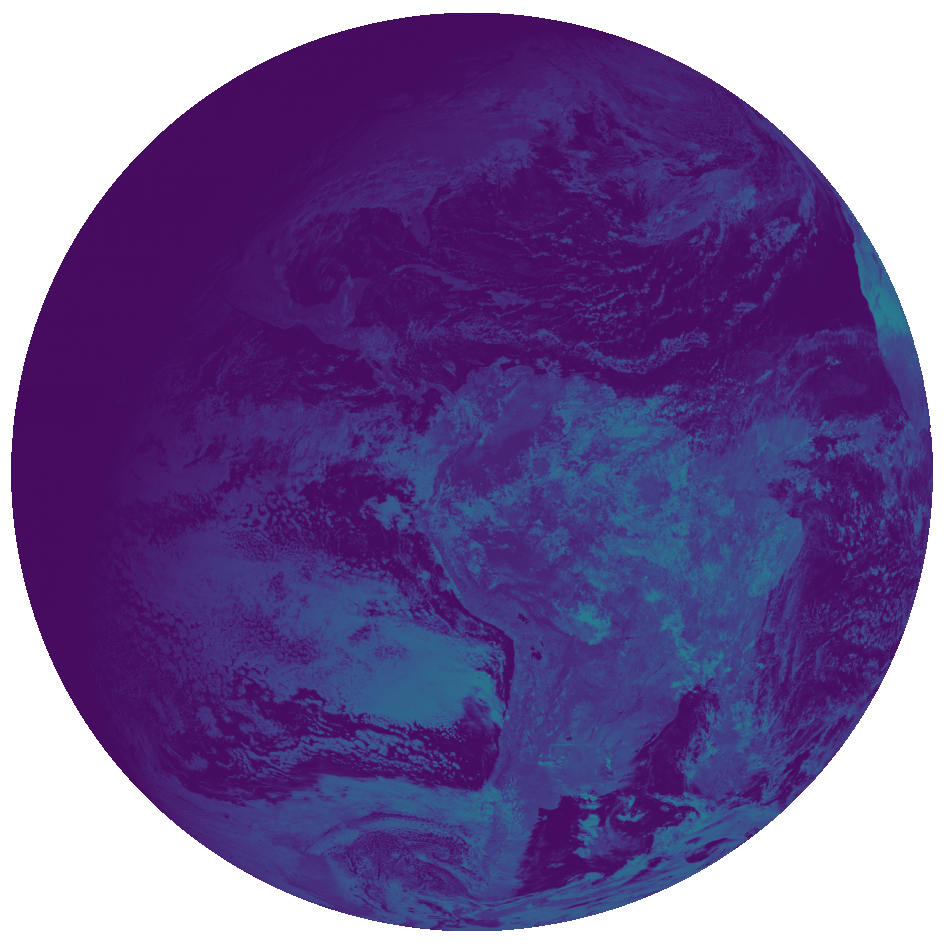

In [46]:
DS = xr.open_dataset('ben.nc')
fig = plt.figure(figsize=(12, 12))
# plt.imshow(DS.Rad, cmap='gray')
plt.imshow(DS.Rad)
plt.axis('off')
plt.savefig(f'{file_name}.png', dpi=300, facecolor='w', edgecolor='w')